# Import

In [1]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [2]:
#import data
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data


# Animal 0 Run

In [ ]:
# Average across time and collapse (angle, sf) into a flat condition axis
TEST_DATA2D = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, animal=0)[..., 40:80]
resp = jnp.nanmean(TEST_DATA2D, axis=-1).transpose(3, 1, 2, 0)  # K x C1 x C2 x N
resp = resp[~jnp.isnan(resp).any(axis=(1, 2, 3))]
K, C1, C2, N = resp.shape

angles = jnp.arange(C1)  # or jnp.arange(0, 360, 30) with period=360
sfs = jnp.array([0.02, 0.04, 0.08, 0.16, 0.32])
sfs = jnp.log2(sfs)
if C2 != len(sfs):
    raise ValueError("C2 does not match number of spatial frequencies")
X_FULL = jnp.stack(jnp.meshgrid(angles, sfs, indexing="ij"), axis=-1).reshape(-1, 2)

# X_FULL = jnp.stack(jnp.meshgrid(jnp.arange(C1), jnp.arange(C2), indexing="ij"), axis=-1).reshape(-1, 2)
Y_FULL = resp.reshape(K, C1 * C2, N)
print(X_FULL.shape)
print(Y_FULL.shape)
# Save files as NPZ
print(np.isnan(X_FULL).any())
print(np.isnan(Y_FULL).any())

(60, 2)
(10, 60, 137)
False
False


In [ ]:
x = np.asarray(X_FULL, dtype=np.float64)   # (C, 2)
y = np.asarray(Y_FULL, dtype=np.float64)   # (K, C, N)

np.savez("data_sated_animal_1.npz", x=x, y=y)

print("saved:", "data_sated_animal_1.npz")
print("x:", x.shape, x.dtype)
print("y:", y.shape, y.dtype)
print("K:", K, "C:", C1*C2, "N:", N,C1)

saved: data_sated_animal_1.npz
x: (60, 2) float64
y: (10, 60, 137) float64
K: 10 C: 60 N: 137 12


: 

In [ ]:

p = "data_sated_animal_1.npz"
d = np.load(p)

print("file:", p)
print("keys:", d.files)

x = d["x"]
y = d["y"]

print("\nshapes/dtypes")
print("x:", x.shape, x.dtype)
print("y:", y.shape, y.dtype)

print("\nX column summaries (c1=angle, c2=sf)")
for i, name in enumerate(["angle", "sf"]):
    col = x[:, i]
    uniq = np.unique(col)
    print(f"{name}: min={col.min():.6g} max={col.max():.6g} n_unique={len(uniq)}")
    print("  first 20 unique:", uniq[:20])

print("\nY summaries")
print("y finite:", np.isfinite(y).all())
print("y min/max:", float(np.nanmin(y)), float(np.nanmax(y)))
print("y mean/std:", float(np.nanmean(y)), float(np.nanstd(y)))
print("any negative?", bool((y < 0).any()))
PY

# Simple 2D Run

In [18]:
# Split trials/conditions
SEED = 1
split = utils.split_data(
    x=X_FULL,
    y=Y_FULL,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    seed=SEED,
)
x_tr, y_tr, _, _, x_te, y_te, *_ = split
x_tr, x_te = jnp.asarray(x_tr), jnp.asarray(x_te)  # keep shape (#cond, 2)



In [21]:


# Hyperparameters (given)
hyperparams = {
    "lambda_gp_angle": 1.8103336,
    "gamma_gp_angle": 4.5379544e-05,
    "beta_gp_angle": 0.12863505,
    "lambda_gp_sf": 0.26290625,
    "gamma_gp_sf": 0.00011522,
    "beta_gp_sf": 0.1991709,
    "lambda_wp_angle": 0.22797374,
    "gamma_wp_angle": 0.00010354,
    "beta_wp_angle": 1.6773869,
    "lambda_wp_sf": 0.36553314,
    "gamma_wp_sf": 2.8193786e-05,
    "beta_wp_sf": 0.27211133,
    "p": 1,
}
V_SCALE = 1e-1
ADAM_OPT = 1e-1
ITERATIONS = 15000
NMC = 32
PERIOD = C1

# Kernels
periodic_gp_angle = lambda a, b: hyperparams["gamma_gp_angle"] * (a == b) + hyperparams["beta_gp_angle"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / hyperparams["lambda_gp_angle"]
)
square_gp_sf = lambda a, b: hyperparams["gamma_gp_sf"] * (a == b) + hyperparams["beta_gp_sf"] * jnp.exp(
    -(a - b) ** 2 / hyperparams["lambda_gp_sf"]
)
kernel_gp = lambda x, y: periodic_gp_angle(x[0], y[0]) * square_gp_sf(x[1], y[1])

periodic_wp_angle = lambda a, b: hyperparams["gamma_wp_angle"] * (a == b) + hyperparams["beta_wp_angle"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / PERIOD) ** 2 / hyperparams["lambda_wp_angle"]
)
square_wp_sf = lambda a, b: hyperparams["gamma_wp_sf"] * (a == b) + hyperparams["beta_wp_sf"] * jnp.exp(
    -(a - b) ** 2 / hyperparams["lambda_wp_sf"]
)
kernel_wp = lambda x, y: periodic_wp_angle(x[0], y[0]) * square_wp_sf(x[1], y[1])

gp = models.GaussianProcess(kernel=kernel_gp, N=N)
wp = models.WishartLRDProcess(kernel=kernel_wp, P=int(hyperparams["p"]), V=V_SCALE * jnp.eye(N), optimize_L=True)

# Init L from train covariance
y_flat = y_tr.reshape(-1, N)
y_flat = y_flat - y_flat.mean(0, keepdims=True)
Sigma_bar = (y_flat.T @ y_flat) / (y_flat.shape[0] - 1)
eps = 1e-3 * jnp.trace(Sigma_bar) / N
wp.L = jnp.linalg.cholesky(Sigma_bar + eps * jnp.eye(N))

lik = models.NormalConditionalLikelihood(N)
joint = models.JointGaussianWishartProcess(gp, wp, lik)

# Variational inference
guide = inference.VariationalNormal(joint.model)
guide.infer(optim.Adam(ADAM_OPT), x_tr, y_tr, n_iter=ITERATIONS, key=jax.random.PRNGKey(SEED))
joint.update_params(guide.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, guide, x_tr)

# Held-out log-likelihood
y_obs = y_te["x_test"]
def one_draw(rng):
    with numpyro.handlers.seed(rng_seed=rng):
        mu, Sigma, _ = posterior.sample(x_te)
    return lik.log_prob(y_obs, mu, Sigma).mean()

mc_keys = jax.random.split(jax.random.PRNGKey(SEED), NMC)
print("Held-out mean log-lik:", float(jax.vmap(one_draw)(mc_keys).mean()))

100%|██████████| 15000/15000 [03:07<00:00, 79.98it/s, init loss: 1167973969.9288, avg. loss [14251-15000]: -35651.2148]


Held-out mean log-lik: 64.69444994504664


In [24]:
print("loss finite?", jnp.isfinite(guide.losses).all())


loss finite? True


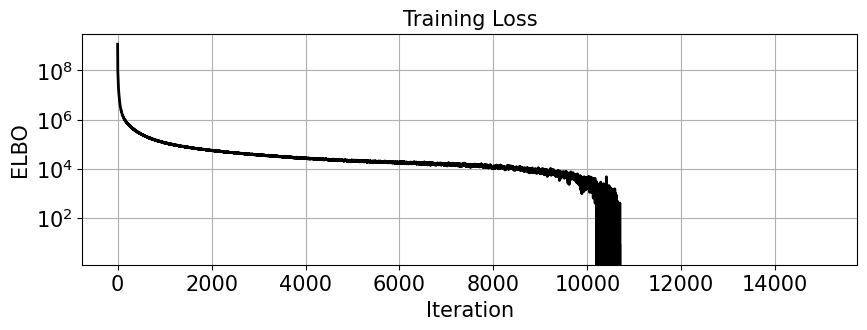

In [22]:
# %% Visualization
visualizations.plot_loss(
    [guide.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

finite? True True
mu_hat shape: (60, 1, 137)
sigma_hat shape: (60, 137, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


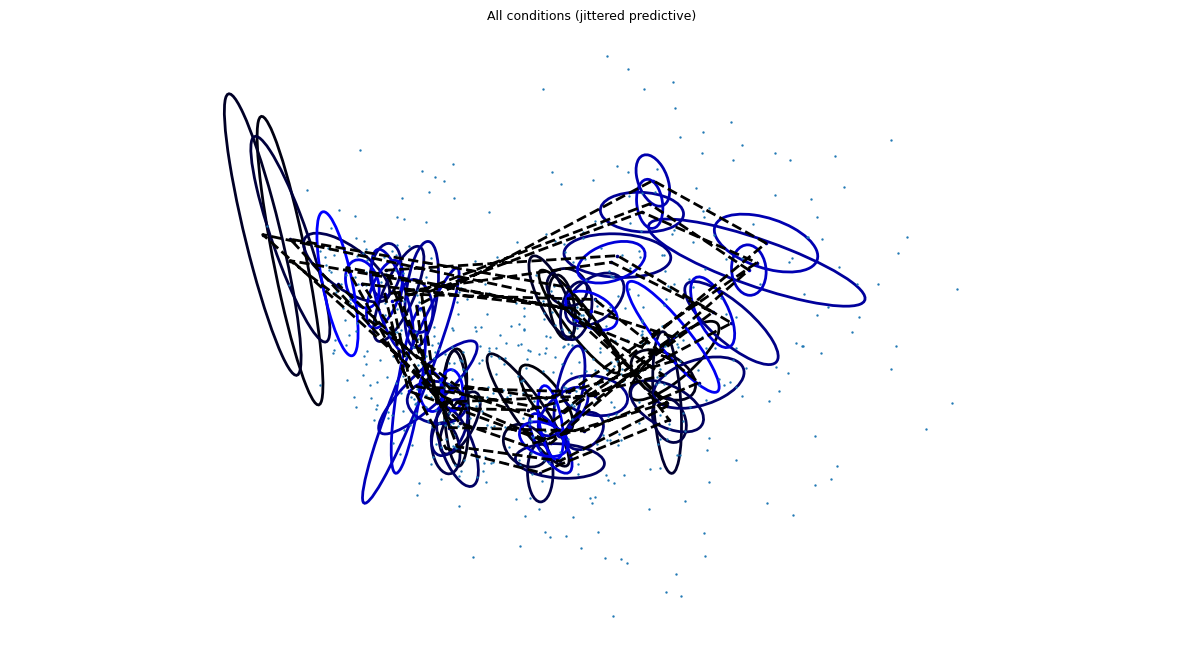

In [66]:
import numpy as np
import numpyro
import numpyro.distributions as dist

JITTER = 1e-5  # tweak if needed

def gp_predict_jitter(gp, X, Y, x, base=1e-12):
    K_X_X = gp.evaluate_kernel(X, X)
    scale = float(jnp.mean(jnp.diag(K_X_X)))
    jitter = base * max(scale, 1.0)
    K_X_X = K_X_X + jitter * jnp.eye(len(X))
    K_X_x = gp.evaluate_kernel(x, X)
    K_x_x = gp.evaluate_kernel(x, x) + jitter * jnp.eye(len(x))

    Ki = jnp.linalg.inv(K_X_X)
    f = jnp.einsum('ij,jm->mi', K_X_x.T @ Ki, Y)
    K = K_x_x - K_X_x.T @ Ki @ K_X_x + jitter * jnp.eye(len(x))
    return f, K

def wp_predict_jitter(wp, X, F, x, base=1e-12, key=jax.random.PRNGKey(0)):
    K_X_X = wp.evaluate_kernel(X, X)
    scale = float(jnp.mean(jnp.diag(K_X_X)))
    jitter = base * max(scale, 1.0)
    K_X_X = K_X_X + jitter * jnp.eye(len(X))
    K_X_x = wp.evaluate_kernel(x, X)
    K_x_x = wp.evaluate_kernel(x, x) + jitter * jnp.eye(len(x))

    Ki = jnp.linalg.inv(K_X_X)
    f = jnp.einsum('ij,mnj->mni', K_X_x.T @ Ki, F)
    K = K_x_x - K_X_x.T @ Ki @ K_X_x + jitter * jnp.eye(len(x))
    F_new = dist.MultivariateNormal(f, covariance_matrix=K).sample(key)
    sigma = wp.f2sigma(F_new)
    return F_new, sigma


# 1) Sample posterior on all conditions with jitter
with numpyro.handlers.seed(rng_seed=0):
    F_draw, G_draw = guide.sample()  # VI draw from trained guide

mu_hat, _ = gp_predict_jitter(joint.gp, x_tr, G_draw.squeeze().T, X_FULL)
F_pred, sigma_hat = wp_predict_jitter(joint.wp, x_tr, F_draw, X_FULL, key=jax.random.PRNGKey(1))

print("finite?", np.isfinite(mu_hat).all(), np.isfinite(sigma_hat).all())

# 2) Point cloud from data
mu_hatT = np.asarray(mu_hat).T
mu_hatNEW = mu_hatT.reshape(mu_hatT.shape[0], 1,mu_hatT.shape[1])
sigma_hat = np.asarray(sigma_hat)

print("mu_hat shape:", mu_hatNEW.shape)
print("sigma_hat shape:", sigma_hat.shape)

visualizations.visualize_pc(
    mu_hatNEW,
    sigma_hat,
    pc=Y_FULL.reshape(-1, N),
    title_str="All conditions (jittered predictive)",
    dotsize=10,
    std=0.1,
)

(60, 1, 137)
mu_ring shape: (12, 1, 137)
sigma_ring shape: (12, 137, 137)
pc_cloud shape: (120, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


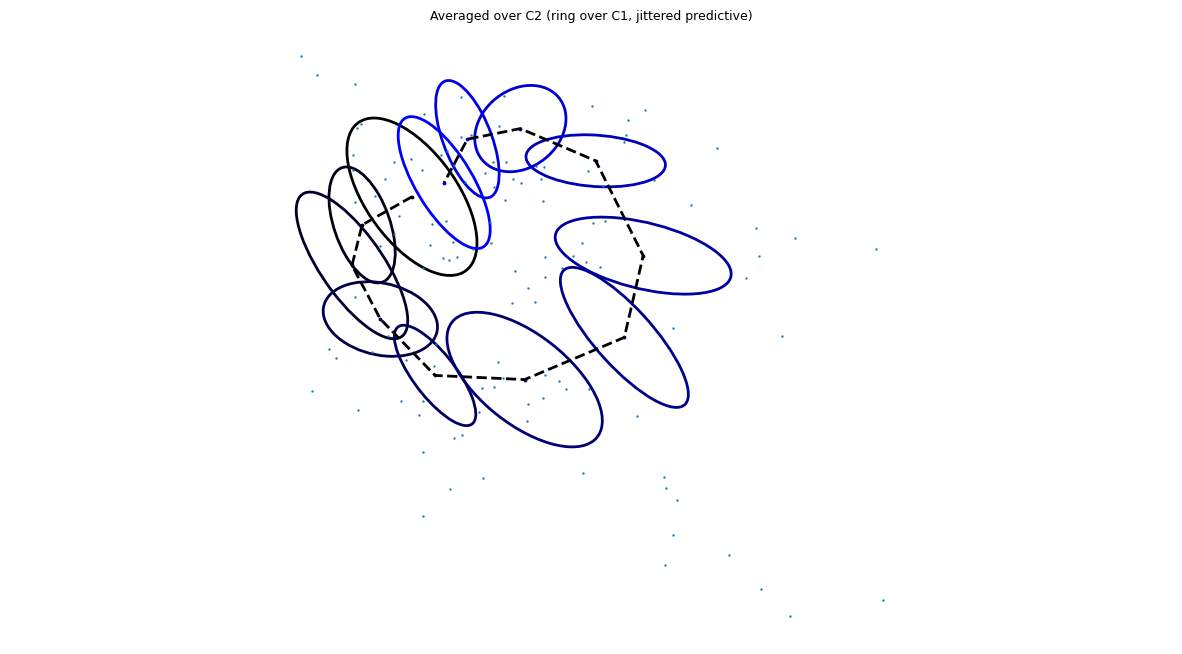

In [87]:
print(mu_hatNEW.shape)
mu_ring = mu_hatNEW.reshape(C1, C2,1, N).mean(axis=1)


print("mu_ring shape:", mu_ring.shape)
sigma_ring = sigma_hat.reshape(C1, C2, N, N).mean(axis=1)
print("sigma_ring shape:", sigma_ring.shape)

Y_FULL_average = Y_FULL.reshape(K, C1, C2, N).mean(axis=2)
pc_cloud = Y_FULL_average.reshape(K*C1,-1)
print("pc_cloud shape:", pc_cloud.shape)
visualizations.visualize_pc(
    mu_ring,
    sigma_ring,
    pc=pc_cloud,
    title_str="Averaged over C2 (ring over C1, jittered predictive)",
    dotsize=12,
    std=0.1,
)

# Compare covariance to emprircal

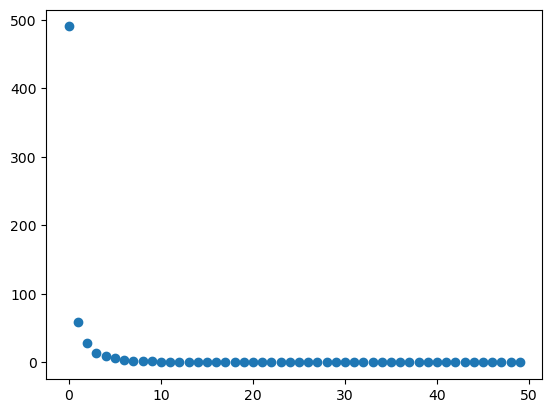

In [88]:
evals_store = np.zeros((12,50))
for iangle in range(12):
    cov_matrix = sigma_ring[iangle,:,:]
    eval, evec = np.linalg.eigh(cov_matrix)
    non_zero_evals = eval[::-1]
    evals_store[iangle,:] = non_zero_evals[:50]
    # plt.scatter(np.arange(len(non_zero_evals)), non_zero_evals)
    # plt.title(f'Angle {iangle}')
    # plt.show()
average_evals = np.mean(evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_evals)), average_evals)





(0.0, 0.5)

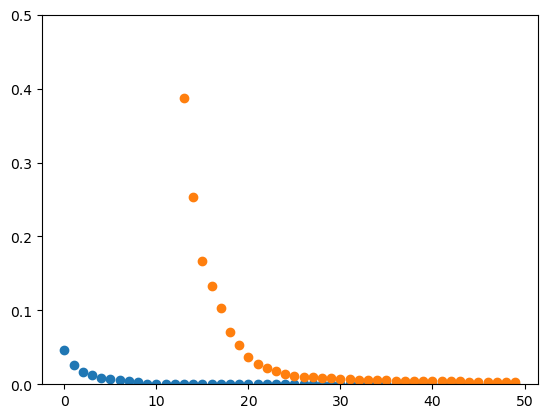

In [89]:
raw_evals_store = np.zeros((12,50))
for iangle in range(12):
    test = Y_FULL_average[:,iangle,:]  # shape (K, N)
    covariance_matrix = np.cov(test, rowvar=False)  # shape (N, N)
    eval, evec = np.linalg.eigh(covariance_matrix)
    non_zero_evals = eval[::-1]
    raw_evals_store[iangle,:] = non_zero_evals[:50]
average_raw_evals = np.mean(raw_evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_raw_evals)), average_raw_evals)
plt.scatter(np.arange(len(average_evals)), average_evals)
plt.ylim(0,0.5)



(12, 137)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


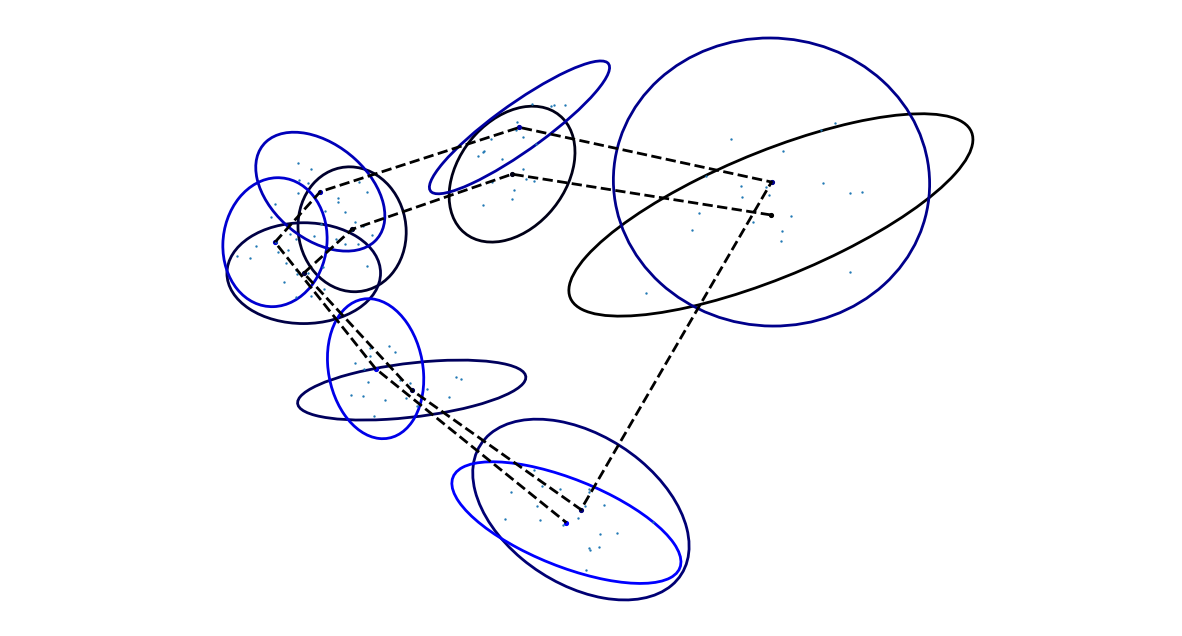

In [90]:
import pandas as pd
empirical_mu = jnp.nanmean(Y_FULL_average,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = Y_FULL_average[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=Y_FULL_average.reshape(Y_FULL_average.shape[0]*Y_FULL_average.shape[1],-1)
)
